In [1]:
!pip install imutils

In [2]:

!pip install tensorflow

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow
from imutils import paths
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
dataset=r'C:\Users\Nishtha Negi\Downloads\Mask Dataset\Mask Dataset'

In [5]:
imagePaths=list(paths.list_images(dataset))

In [6]:
data=[]
labels=[]
for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)
# labels

In [7]:
data=np.array(data,dtype='float32')
labels=np.array(labels)
#data

In [8]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [9]:
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=0.20,random_state=10,stratify=labels)

In [10]:
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True)

In [11]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [12]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [13]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)

In [14]:
for layer in baseModel.layers:
    layer.trainable=False

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [16]:
learning_rate=0.001
Epochs=10
BS=12

opt= tensorflow.keras.optimizers.Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

H=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X,test_Y),
    validation_steps=len(test_X)//BS,
    epochs=Epochs
)

C:\Users\Nishtha Negi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
91/91 [==============================] - 55s 566ms/step - loss: 0.2165 - accuracy: 0.9200 - val_loss: 0.0500 - val_accuracy: 0.9819
Epoch 2/10
91/91 [==============================] - 72s 792ms/step - loss: 0.0738 - accuracy: 0.9789 - val_loss: 0.0613 - val_accuracy: 0.9783
Epoch 3/10
91/91 [==============================] - 104s 1s/step - loss: 0.0441 - accuracy: 0.9881 - val_loss: 0.0419 - val_accuracy: 0.9855
Epoch 4/10
91/91 [==============================] - 98s 1s/step - loss: 0.0488 - accuracy: 0.9871 - val_loss: 0.0496 - val_accuracy: 0.9819
Epoch 5/10
91/91 [==============================] - 84s 918ms/step - loss: 0.0363 - accuracy: 0.9881 - val_loss: 0.0423 - val_accuracy: 0.9855
Epoch 6/10
91/91 [==============================] - 71s 777ms/step - loss: 0.0345 - accuracy: 0.9871 - val_loss: 0.0464 - val_accuracy: 0.9819
Epoch 7/10
91/91 [==============================] - 72s 792ms/step - loss: 0.0258 - accuracy: 0.9908 - val_loss: 0.0360 - val_accuracy: 0.9855
Epoc

In [17]:
model.save(r'C:\model_save\mobilenet_v2.model')

INFO:tensorflow:Assets written to: C:\model_save\mobilenet_v2.model\assets


INFO:tensorflow:Assets written to: C:\model_save\mobilenet_v2.model\assets


In [18]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=lb.classes_))

23/23 [==============================] - 15s 527ms/step
              precision    recall  f1-score   support

   with_mask       0.97      0.99      0.98       138
without_mask       0.99      0.97      0.98       138

    accuracy                           0.98       276
   macro avg       0.98      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276



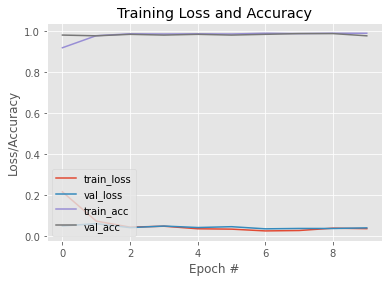

In [20]:
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")